<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/causalml/prac_uplift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd /content/drive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/causalML

/content/drive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/causalML


In [3]:
ls

prac_uplift.ipynb


In [4]:
!pip install causalml

     |████████████████████████████████| 3.5MB 2.9MB/s 
     |████████████████████████████████| 276kB 29.7MB/s 
     |████████████████████████████████| 1.8MB 23.9MB/s 
  Created wheel for causalml: filename=causalml-0.7.0-cp36-cp36m-linux_x86_64.whl size=471464 sha256=b6e8cf513550497d5507135451621558480470605a7895831787746de009ae68
  Stored in directory: /root/.cache/pip/wheels/9a/b4/77/8ab9acc1734668cc9a607b8078702fa213bd138097e5cbc7b2
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394111 sha256=a5494ed76b99fec08c59238fe094b0277e58ccc25b648d68e7710ab45173912c
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built causalml shap


In [0]:
def time_watch(func):
    """時間計測用デコレータ関数
    
    Parameters
    -----
    func : function
        実行したい関数

    """
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start = datetime.datetime.today()
        result = func(*args, **kwargs)
        end = datetime.datetime.today()
        print("実行時間:{time}".format(time=end - start))
        return result
    return wrapper

# uplift値を算出するupliftモデルの練習

In [0]:
# utils
import datetime
import functools
from io import BytesIO
from PIL import Image
import pprint

## dataset
http://ailab.criteo.com/criteo-uplift-prediction-dataset/

In [0]:
import pandas as pd

In [0]:
DATADIR = "../datasets"
#csv_data_file = "criteo-uplift-v2.csv"
csv_data_file = "sampling_1000000_seed7.csv"
data_path  = DATADIR + "/"  + csv_data_file

In [0]:
@time_watch
def sampling_data(file_path, sample_num):
    """
    データをランダムにサンプリングして読み込む

    Parameters
    -----
    file_path : string
    sample_num : int

    Retruns
    -----
    df : pandas.Dataframe
    """
    df = pd.read_csv(file_path).sample(n=sample_num, random_state=7).reset_index(drop=True)
    return df

In [10]:
# （元データが大きすぎるので）ランダムに抽出したcsvファイルを読み込むかフラグ
READ_SAMPLING_DATA_FLAG = True

# ランダムに抽出する行数
sample_num = 1000000

if READ_SAMPLING_DATA_FLAG:
    criteo_data = pd.read_csv(data_path)
else:
    criteo_data = sampling_data(file_path=data_path, sample_num=sample_num)

print("解析対象のデータサイズ:{size}".format(size=criteo_data.shape))
criteo_data.head()

解析対象のデータサイズ:(1000000, 16)


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,26.140824,10.059654,8.848786,4.679882,10.280525,4.115453,-3.993764,4.833815,3.790775,13.190056,5.300375,-0.168679,1,0,0,0
1,25.589651,10.059654,9.032961,4.679882,10.280525,4.115453,-5.987667,4.833815,3.872698,13.190056,5.300375,-0.168679,1,0,0,0
2,12.616365,10.059654,8.944798,4.679882,10.280525,4.115453,0.294443,4.833815,3.920995,13.190056,5.300375,-0.168679,1,0,0,0
3,18.428264,10.059654,8.602762,3.907662,10.280525,4.115453,-1.288207,4.833815,3.927254,21.416100,5.300375,-0.168679,1,0,0,0
4,22.243701,10.059654,8.214383,4.679882,10.280525,4.115453,-5.116672,4.833815,3.971858,13.190056,5.300375,-0.168679,1,0,0,0


In [0]:
feature_columns = ["f0", "f1", "f2", "f3", "f4", "f5", "f6", "f7", "f8", "f9", "f10", "f11"]
treatment_column = "treatment"
outcome_column = "conversion"

In [12]:
# 統計量の確認
criteo_data.describe()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,19.627545,10.069923,8.445923,4.179984,10.339064,4.028555,-4.158878,5.100977,3.933565,16.046565,5.333516,-0.170995,0.849992,0.002893,0.047355,0.030917
std,5.374274,0.104755,0.299113,1.334824,0.343399,0.432105,4.577827,1.203275,0.056740,7.054590,0.168441,0.022845,0.357079,0.053709,0.212397,0.173093
min,12.616365,10.059654,8.214383,-7.234371,10.280525,-8.912209,-28.605448,4.833815,3.648292,13.190056,5.300375,-1.284443,0.000000,0.000000,0.000000,0.000000
25%,12.616365,10.059654,8.214383,4.679882,10.280525,4.115453,-6.699321,4.833815,3.910792,13.190056,5.300375,-0.168679,1.000000,0.000000,0.000000,0.000000
50%,21.930735,10.059654,8.214383,4.679882,10.280525,4.115453,-2.411115,4.833815,3.971858,13.190056,5.300375,-0.168679,1.000000,0.000000,0.000000,0.000000
75%,24.438607,10.059654,8.719911,4.679882,10.280525,4.115453,0.294443,4.833815,3.971858,13.190056,5.300375,-0.168679,1.000000,0.000000,0.000000,0.000000
max,26.745255,15.640628,9.051961,4.679882,20.677034,4.115453,0.294443,11.998389,3.971858,65.086958,6.473910,-0.168679,1.000000,1.000000,1.000000,1.000000


In [13]:
# コンバージョンしたデータ数のカウント
criteo_data[criteo_data[outcome_column] == 1].shape

(2893, 16)

### データの前処理

In [14]:
# 欠損値のチェック
criteo_data.isnull().sum()

f0            0
f1            0
f2            0
f3            0
f4            0
f5            0
f6            0
f7            0
f8            0
f9            0
f10           0
f11           0
treatment     0
conversion    0
visit         0
exposure      0
dtype: int64

### 標準化

In [0]:
from sklearn.preprocessing import StandardScaler

In [0]:
@time_watch
def convert_std_df(df):
    """
    データフレーム内のデータの標準化を行う

    Parameters
    -----
    df : pandas.Dataframe

    Returns
    -----
    std_df : pandas.Dataframe
    """
    sc = StandardScaler()
    std_ndarray = sc.fit_transform(df)
    std_df = pd.DataFrame(data=std_ndarray, columns=df.columns)
    return std_df

In [17]:
criteo_data[feature_columns] = convert_std_df(criteo_data[feature_columns])

実行時間:0:00:00.245269


### 介入変数の置き換え

In [0]:
criteo_data.loc[criteo_data[treatment_column] == 1, treatment_column] = "treatment"
criteo_data.loc[criteo_data[treatment_column] == 0, treatment_column] = "control"

In [19]:
criteo_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,treatment,conversion,visit,exposure
0,1.211937,-0.098024,1.346861,0.374504,-0.17047,0.201105,0.036068,-0.22203,-2.516575,-0.404915,-0.196755,0.101372,treatment,0,0,0
1,1.109379,-0.098024,1.962597,0.374504,-0.17047,0.201105,-0.399489,-0.22203,-1.072741,-0.404915,-0.196755,0.101372,treatment,0,0,0
2,-1.304582,-0.098024,1.667848,0.374504,-0.17047,0.201105,0.972803,-0.22203,-0.221535,-0.404915,-0.196755,0.101372,treatment,0,0,0
3,-0.223152,-0.098024,0.524347,-0.204014,-0.17047,0.201105,0.627082,-0.22203,-0.111233,0.761141,-0.196755,0.101372,treatment,0,0,0
4,0.486793,-0.098024,-0.774089,0.374504,-0.17047,0.201105,-0.209225,-0.22203,0.674879,-0.404915,-0.196755,0.101372,treatment,0,0,0


### 訓練データと検証データに分割

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_df, test_df = train_test_split(criteo_data, train_size=0.8, random_state=7)

In [22]:
train_df.shape, test_df.shape

((800000, 16), (200000, 16))

## upliftTreeModel(Tree-Based Algorithms)

### モデル定義

In [0]:
from causalml.inference.tree import UpliftTreeClassifier

In [0]:
evaluationFunction = "KL"
min_samples_treatment = 50
control_name = "control"
max_depth=5

In [0]:
uplift_model = UpliftTreeClassifier(max_depth=max_depth,
                                    evaluationFunction=evaluationFunction,
                                    min_samples_treatment=min_samples_treatment,
                                    control_name=control_name)

### モデルの訓練

In [35]:
uplift_model.fit(
    X=train_df[feature_columns].values,
    treatment=train_df[treatment_column].values,
    y=train_df[outcome_column].values
)

### 結果の描画

In [0]:
from IPython.display import Image
from causalml.inference.tree import uplift_tree_plot

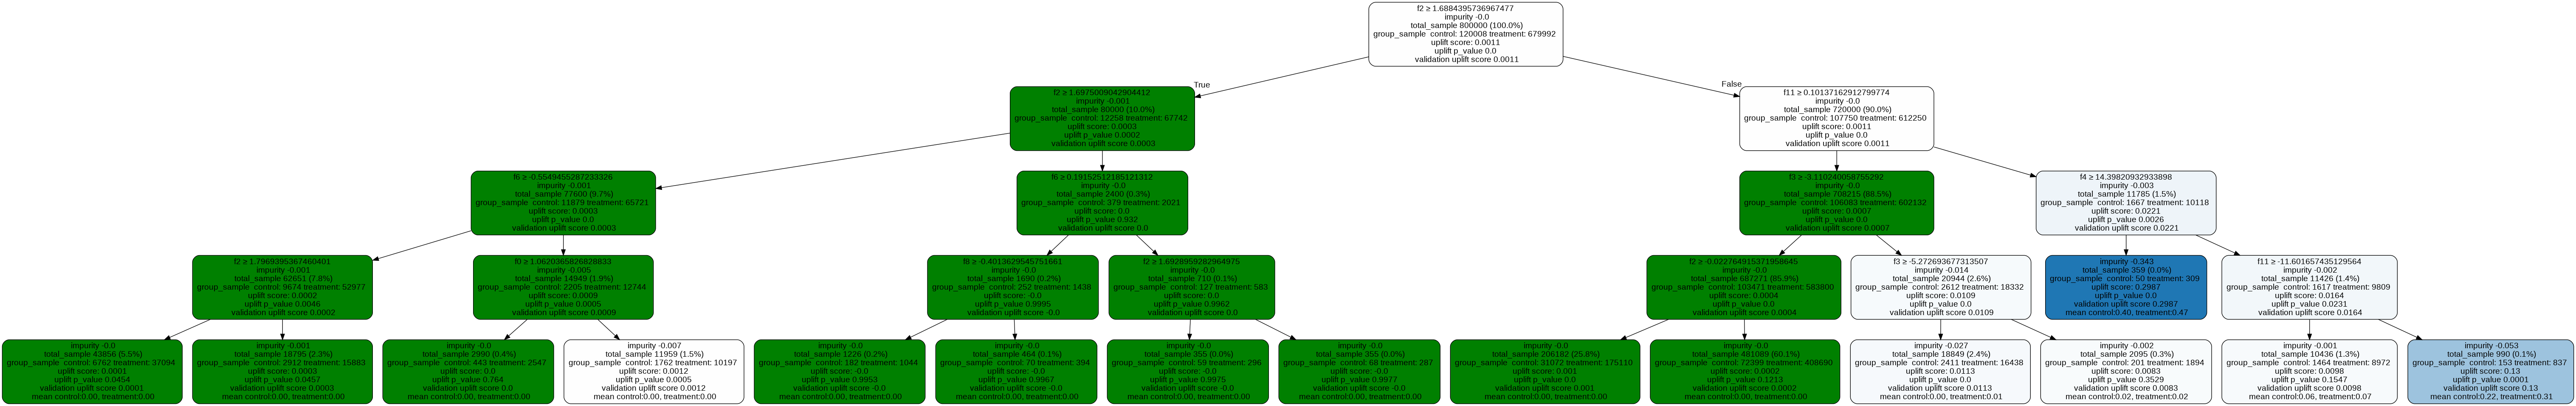

In [48]:
graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, feature_columns)
train_result_img = Image.open(BytesIO(graph.create_png()))
train_result_img

In [0]:
img_file_name = "uplift_result" + datetime.datetime.now().strftime('%Y%m%d_%H%M%S') + ".png"
train_result_img.save(img_file_name)

### 検証精度の測定
uplift用の評価指標（AUUC）